In [1]:

from datetime import datetime

import torch
from torch.utils.data import DataLoader

from datasets.LabeledImageDataset import LabeledImageDataset
from models.resnet import Resnet50Model, Resnet18Model
from train import train_classifier
from utils import plot_model_metrics, oversample_dataset
from utils import reduce_dataset, split_dataset, undersample_dataset
from torchvision.transforms import v2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

batch_size = 128
dataset = LabeledImageDataset("data/candidates")
dataset = reduce_dataset(dataset, discard_ratio=0.0)
train_dataset, test_dataset = split_dataset(dataset, train_ratio=0.7)
train_dataset = undersample_dataset(train_dataset)

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=True, )

model = Resnet18Model(hidden_layers=2, units_per_layer=2048, dropout=0.4)

print(f"Dataset: {len(train_dataset):,} training, {len(test_dataset):,} testing")


Device: cuda:0
Dataset: 296 training, 2,056 testing


In [2]:
print(model)

Resnet18Model(
  (pretrained_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [3]:
print(f"Training starts {datetime.now().isoformat()}")

Training starts 2024-11-18T14:23:42.178519


In [4]:

model = model.to(device)
model, model_metrics = train_classifier(model, train_loader, test_loader, device,
                                        learning_rate=0.0001,
                                        max_epochs=20,
                                        checkpoint_every=1,
                                        eval_every=1)


Epoch 1 training: 100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Train: 1/20: loss:0.6909269293149313


Epoch 1 testing: 100%|██████████| 17/17 [00:04<00:00,  3.58it/s]


Test: 1/20: loss:0.6636321264154771, accuracy:0.8855698529411765, precision:0.10009652016572433, recall:0.3514705882352941, f1:0.15400027389191476, mcc:0.1415101343413954, epoch:0


Epoch 2 training: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]


Train: 2/20: loss:0.673925499121348


Epoch 2 testing: 100%|██████████| 17/17 [00:05<00:00,  3.22it/s]


Test: 2/20: loss:0.6377187581623301, accuracy:0.9048713235294118, precision:0.1853202257181496, recall:0.42222222222222217, f1:0.2386535392188912, mcc:0.2302766787002796, epoch:1


Epoch 3 training: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Train: 3/20: loss:0.6530470848083496


Epoch 3 testing: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Test: 3/20: loss:0.6397354357382831, accuracy:0.7881433823529411, precision:0.1016052517443539, recall:0.7258403361344539, f1:0.1730912054367065, mcc:0.21701957154673834, epoch:2


Epoch 4 training: 100%|██████████| 3/3 [00:00<00:00,  3.65it/s]


Train: 4/20: loss:0.6333055098851522


Epoch 4 testing: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Test: 4/20: loss:0.6455625961808598, accuracy:0.7035845588235294, precision:0.08404425336049985, recall:0.9068627450980393, f1:0.15261382673240398, mcc:0.2207213560610981, epoch:3


Epoch 5 training: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Train: 5/20: loss:0.6084669828414917


Epoch 5 testing: 100%|██████████| 17/17 [00:05<00:00,  3.24it/s]


Test: 5/20: loss:0.6593886263230267, accuracy:0.6323529411764706, precision:0.07208743319410574, recall:0.9122549019607843, f1:0.13163887720852246, mcc:0.19255190423207846, epoch:4


Epoch 6 training: 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


Train: 6/20: loss:0.5724174777666727


Epoch 6 testing: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]


Test: 6/20: loss:0.5894574207418105, accuracy:0.7302389705882353, precision:0.08928181057421794, recall:0.8480392156862745, f1:0.15905801880548903, mcc:0.21866441232238482, epoch:5


Epoch 7 training: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Train: 7/20: loss:0.5447288354237875


Epoch 7 testing: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Test: 7/20: loss:0.4999791751889622, accuracy:0.7858455882352942, precision:0.10801252114403309, recall:0.763655462184874, f1:0.18492474206594278, mcc:0.2333531825865127, epoch:6


Epoch 8 training: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Train: 8/20: loss:0.5074267983436584


Epoch 8 testing: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]


Test: 8/20: loss:0.44932323869536905, accuracy:0.8088235294117647, precision:0.1174432375226665, recall:0.7106442577030813, f1:0.1979917333634555, mcc:0.2404382994549215, epoch:7


Epoch 9 training: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]


Train: 9/20: loss:0.46228407820065814


Epoch 9 testing: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s]


Test: 9/20: loss:0.6265504570568309, accuracy:0.6783088235294118, precision:0.09862563184443802, recall:0.9724789915966388, f1:0.17169961935049127, mcc:0.23645389331970362, epoch:8


Epoch 10 training: 100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


Train: 10/20: loss:0.4791923761367798


Epoch 10 testing: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Test: 10/20: loss:0.40483253843644085, accuracy:0.8244485294117647, precision:0.14045169143634617, recall:0.7921568627450979, f1:0.2327997846303189, mcc:0.2775387409994887, epoch:9


Epoch 11 training: 100%|██████████| 3/3 [00:00<00:00,  3.80it/s]


Train: 11/20: loss:0.4123485287030538


Epoch 11 testing: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]


Test: 11/20: loss:0.38074475000886354, accuracy:0.8304227941176471, precision:0.12203215127902164, recall:0.7450980392156863, f1:0.20625990448241172, mcc:0.2458890483637899, epoch:10


Epoch 12 training: 100%|██████████| 3/3 [00:00<00:00,  3.73it/s]


Train: 12/20: loss:0.39170798659324646


Epoch 12 testing: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]


Test: 12/20: loss:0.6537299541866078, accuracy:0.6976102941176471, precision:0.08464310907738946, recall:0.8980392156862744, f1:0.15147173850371168, mcc:0.2163139460906142, epoch:11


Epoch 13 training: 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]


Train: 13/20: loss:0.4217669169108073


Epoch 13 testing: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]


Test: 13/20: loss:0.40313828517408934, accuracy:0.8244485294117647, precision:0.12223008362063835, recall:0.7967320261437908, f1:0.20545205054507362, mcc:0.26051062875416114, epoch:12


Epoch 14 training: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]


Train: 14/20: loss:0.39089922110239667


Epoch 14 testing: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Test: 14/20: loss:0.36276421126197367, accuracy:0.8432904411764706, precision:0.12568374119961404, recall:0.6756302521008403, f1:0.2088754751522565, mcc:0.24724131913973046, epoch:13


Epoch 15 training: 100%|██████████| 3/3 [00:00<00:00,  3.77it/s]


Train: 15/20: loss:0.38143744071324664


Epoch 15 testing: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Test: 15/20: loss:0.5331288488472209, accuracy:0.7637867647058824, precision:0.09891445940154897, recall:0.8361344537815126, f1:0.17258935587185717, mcc:0.2309279094747624, epoch:14


Epoch 16 training: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]


Train: 16/20: loss:0.33057639996210736


Epoch 16 testing: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]


Test: 16/20: loss:0.5551122146494248, accuracy:0.7555147058823529, precision:0.0926286847391617, recall:0.7637254901960785, f1:0.16288602024748797, mcc:0.2132726496017982, epoch:15


Epoch 17 training: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]


Train: 17/20: loss:0.3080758551756541


Epoch 17 testing: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Test: 17/20: loss:0.35931677853359895, accuracy:0.8391544117647058, precision:0.1226677310289056, recall:0.723529411764706, f1:0.20604660975082353, mcc:0.2505864590178733, epoch:16


Epoch 18 training: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]


Train: 18/20: loss:0.31662681698799133


Epoch 18 testing: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]


Test: 18/20: loss:0.42934920332011056, accuracy:0.8051470588235294, precision:0.11013894610567769, recall:0.7245098039215686, f1:0.18876635507508052, mcc:0.23488666836162894, epoch:17


Epoch 19 training: 100%|██████████| 3/3 [00:00<00:00,  3.69it/s]


Train: 19/20: loss:0.2797437409559886


Epoch 19 testing: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]


Test: 19/20: loss:0.6128154730095583, accuracy:0.7297794117647058, precision:0.08893912595627983, recall:0.7906162464985994, f1:0.15631172832316206, mcc:0.2079644553275524, epoch:18


Epoch 20 training: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Train: 20/20: loss:0.29333388805389404


Epoch 20 testing: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]


Test: 20/20: loss:0.3870233507717357, accuracy:0.8272058823529411, precision:0.11931866009433649, recall:0.7637254901960784, f1:0.20272363451945163, mcc:0.25259384198323953, epoch:19


Training ends 2024-11-18T14:25:52.166675
Test accuracy: 0.8272058823529411
Test precision: 0.11931866009433649
Test recall: 0.7637254901960784
Test f1: 0.20272363451945163
Test mcc: 0.25259384198323953


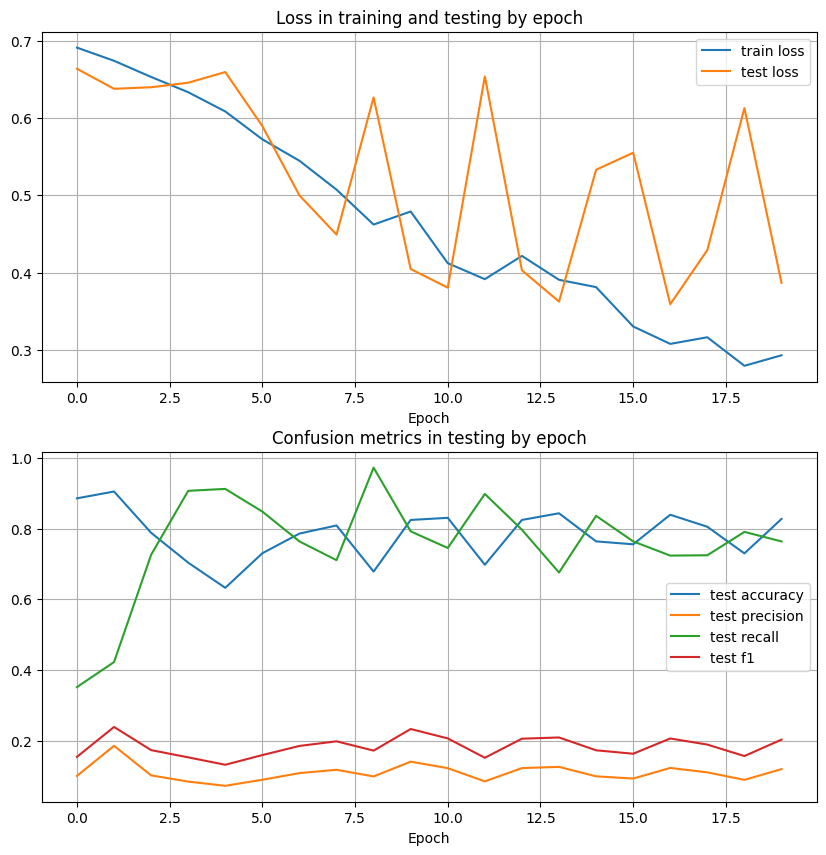

In [5]:

print(f"Training ends {datetime.now().isoformat()}")
for metric in ["accuracy", "precision", "recall", "f1", "mcc"]:
    if len(model_metrics[f"test_{metric}"]) > 0:
        print(f"Test {metric}:", model_metrics[f"test_{metric}"][-1])

plot_model_metrics(model_metrics)

In [6]:
torch.save(model,"model.pth")